# Backgorund Matching

Notebook utilizado para estudiar la detección de padrones dentro de eventos consideramos backgroun. El background será generado usando direcciones de eventos aleatorias diferentes de las direcciones de MC.

In [1]:
import cv2 as cv
import uproot
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sn

import random

In [2]:
def magnitude(vector): 
    #Funcion para calcular radio de eventos al centro del detector
    
    norm = []
    for vec in vector:
    	norm.append(np.linalg.norm(vec))

    return np.array(norm, dtype = np.float32)

# 1 - Extraer datos

In [12]:
file = uproot.open("/snoplus simulations/electron bulk/center point/random direction/High Statistic/simu_Analysis_elec_5MeV.root")
file.keys()

['T;64', 'T;63', 'pmt;2', 'pmt;1']

In [13]:
pmt_info = file['pmt;1']
pmt_info.keys()

['pmt_id', 'pmt_pos_xyz', 'pmt_pos_sph', 'pmt_type']

In [14]:
data1 = file['T;64']
data1.keys()

['evtid',
 'mcID',
 'energy',
 'mc_position',
 'mc_momentum',
 'position',
 'momentum',
 'hit_pmtid',
 'hit_pmttime',
 'hit_residual',
 'hit_type']

## 1.1 - EV info

In [15]:
#evtid = np.array(data1['evtid'], dtype = np.int16)
mcID = np.array(data1['mcID'], dtype = np.int16)
mc_position = np.array(data1['mc_position'])   #-> Position Generation
mc_momentum = np.array(data1['mc_momentum'])   #-> IMPORTANT: Direction of simulated event
position = np.array(data1['position'])        
hit_pmtid = np.array(data1['hit_pmtid'], dtype = np.int16)
time_residual = np.array(data1['hit_residual'])
hit_type = np.array(data1['hit_type'], dtype = np.int16)

In [16]:
mc_position

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

## 1.2 - PMT info

In [17]:
pmt_id = np.array(pmt_info['pmt_id'], dtype = np.int16)
pmt_pos_xyz = np.array(pmt_info['pmt_pos_xyz'])
pmt_pos_sph = np.array(pmt_info['pmt_pos_sph'])
pmt_type = np.array(pmt_info['pmt_type'], dtype = np.int16)

# 2 - Select Data

## 2.1 - Extract  valid PMT id

In [18]:
valid_pmt_id = np.array(np.where(pmt_type == 1)[0])   # PMT valid ID match with index of where pmt_type=1

valid_id_info_ev_i = np.array(np.where(np.in1d(hit_pmtid, valid_pmt_id))[0])
valid_id_info_ev_i

array([        0,         1,         2, ..., 139457001, 139457002,
       139457003], dtype=int64)

### 2.1.1 - Extraer información valida de PMT info

In [19]:
valid_pmt_xyz = []

for i_dx in valid_pmt_id:
    valid_pmt_xyz.append(pmt_pos_xyz[i_dx])
valid_pmt_xyz = np.array(valid_pmt_xyz)

## 2.2 - Extracción y cortes en Datos de Eventos Validos

In [21]:
#params to adjust the cuts--------------------------------------------
#Split Data
split = 10
#time cut
inf_cut = -5
up_cut = 15

#radial cut
radi_cut_method = False   #If true, apply radial cuts given by rad_cut_val to data
rad_cut_val = 5500.0
#--------------------------------------------------------------------------


# Dividir valid_id_info_ev_i en partes
valid_info_ev_split = np.array_split(valid_id_info_ev_i, split)  #---> split(array, parts)

#variables to save: with time residual cuts and radi cut (radi cut is optional, depends on the simulation)
multi_time_residual_cut = []
multi_cos_angle_cut = []
#multi_position_cut = []
multi_mc_momentum_cut = []
multi_mc_ID_cut = []
multi_hit_xyz_cut = []  #save the coordinates of hits to be used to generate the background with (random direction != mc_momentum)

#loop over valid_info_ev_split
for n_loop, split_array in enumerate(valid_info_ev_split):
    print('slipt nº:', n_loop)
    # extract all valid simulated info 
    multi_mc_ID = []
    multi_time_residual = []
    multi_pmt_id_hit = []
    #multi_position = []
    #multi_mc_position = []
    multi_mc_momentum = []   
    multi_xyz_hit = []

    for valid_i in split_array:
        multi_mc_ID.append(mcID[valid_i])
        multi_time_residual.append(time_residual[valid_i])
        multi_pmt_id_hit.append(hit_pmtid[valid_i])
        #multi_position.append(position[valid_i])
        #multi_mc_position.append(mc_position[valid_i])
        multi_mc_momentum.append(mc_momentum[valid_i])
    multi_time_residual = np.array(multi_time_residual)
    multi_pmt_id_hit = np.array(multi_pmt_id_hit)
    #multi_position = np.array(multi_position)

    for id_i in multi_pmt_id_hit:
        multi_xyz_hit.append(pmt_pos_xyz[id_i])
    multi_xyz_hit = np.array(multi_xyz_hit)

    #Radial Cut:
    if radi_cut_method == True:
        print('In radi_cut, split nº: ', n_loop)
        #mc_position_norm = magnitude(multi_mc_position)
        position_norm = magnitude(multi_position)
        max_radi = rad_cut_val
        radi_condition = (position_norm < max_radi)
        index_cut_radi = np.array(np.where(radi_condition)[0])

        #variables to extract
        multi_time_residual = np.extract(radi_condition, multi_time_residual)
        multi_pmt_id_hit = np.extract(radi_condition, multi_pmt_id_hit)

        multi_mc_ID_radi_cut = []
        multi_mc_momentum_radi_cut = []
        multi_position_radi_cut = []
        multi_xyz_hit_radi_cut = [] 

        for j_dx in index_cut_radi:
            multi_mc_momentum_radi_cut.append(multi_mc_momentum[j_dx])
            multi_position_radi_cut.append(multi_position[j_dx])          #HERE
            multi_mc_ID_radi_cut.append(multi_mc_ID[j_dx])

        for id_i in multi_pmt_id_hit:
            multi_xyz_hit_radi_cut.append(pmt_pos_xyz[id_i])

        multi_mc_ID = multi_mc_ID_radi_cut
        multi_mc_momentum = multi_mc_momentum_radi_cut   #HERE
        multi_position = multi_position_radi_cut
        multi_xyz_hit = multi_xyz_hit_radi_cut
        
        #freed memory
        multi_mc_ID_radi_cut = None
        multi_mc_momentum_radi_cut = None
        multi_position_radi_cut = None
        multi_xyz_hit_radi_cut = None
        radi_condition = None
        index_cut_radi = None
        
    #cos(alpha) calculation -> Uses the definition of scalar product
    multi_cos_angle = []
    N = np.shape(multi_xyz_hit)[0]

    print('computing cos(alpha)')
    for k in range(N):
        #event_direction = np.array([0,0,-1])
        event_direction = multi_mc_momentum[k]
        scalar_product = np.dot(multi_xyz_hit[k], event_direction)
        norm_1 = np.linalg.norm(event_direction)
        norm_2 = np.linalg.norm(multi_xyz_hit[k])
        cos_val = scalar_product/(norm_1*norm_2)
        
        multi_cos_angle.append(cos_val)

    #Time residual cut:
    print('doing time residual cuts')
    for i in np.where((multi_time_residual > inf_cut) & (multi_time_residual < up_cut))[0]:
        multi_time_residual_cut.append(multi_time_residual[i])
        multi_cos_angle_cut.append(multi_cos_angle[i])
        #multi_position_cut.append(multi_position[i])
        multi_mc_momentum_cut.append(multi_mc_momentum[i])
        multi_mc_ID_cut.append(multi_mc_ID[i])
        multi_hit_xyz_cut.append(multi_xyz_hit[i])

    #freed memory
    multi_cos_angle = None

    #freen memory:    
    multi_mc_ID = None
    multi_time_residual = None
    multi_pmt_id_hit = None
    multi_position = None
    multi_mc_position = None
    multi_mc_momentum = None
    multi_xyz_hit = None
    
#multi_position_cut = np.array(multi_position_cut)
multi_mc_momentum_cut = np.array(multi_mc_momentum_cut)
multi_mc_ID_cut = np.array(multi_mc_ID_cut, dtype = np.int16)
multi_hit_xyz_cut = np.array(multi_hit_xyz_cut)

slipt nº: 0
computing cos(alpha)
doing time residual cuts
slipt nº: 1
computing cos(alpha)
doing time residual cuts
slipt nº: 2
computing cos(alpha)
doing time residual cuts
slipt nº: 3
computing cos(alpha)
doing time residual cuts
slipt nº: 4
computing cos(alpha)
doing time residual cuts
slipt nº: 5
computing cos(alpha)
doing time residual cuts
slipt nº: 6
computing cos(alpha)
doing time residual cuts
slipt nº: 7
computing cos(alpha)
doing time residual cuts
slipt nº: 8
computing cos(alpha)
doing time residual cuts
slipt nº: 9
computing cos(alpha)
doing time residual cuts


# 2.3 - Separate Event Information 

In [22]:
break_i = [0] #List of indices where data change of event ID

N_evts = len(multi_mc_ID_cut)
for i in range(N_evts-1):
    if multi_mc_ID_cut[i] != multi_mc_ID_cut[i+1]:
        break_i.append(i+1)    
break_i = np.array(break_i, dtype = np.int32)

# 3 - Observe 2DHist for Δ vs. α - MultiEV/Single EV

## 3.1 - Single event Histograms

In [330]:
#Escoger un eventID para observar y hacer match

#Eventos interesantes: ID=(1,2,3)
id_i = 2
i = break_i[id_i]
f = break_i[id_i + 1]

#multi_mc_ID_cut[i:f]

#select event data
time_residual_ev = np.array(multi_time_residual_cut[i:f])
cos_angel_ev = np.array(multi_cos_angle_cut[i:f])
hit_xyz_ev = np.array(multi_hit_xyz_cut[i:f])

#create fake-random directions to compute a fake-cos_alpha

#random coordinates
x1 = random.uniform(-1,1)
x2 = random.uniform(-1,1)
x3 = random.uniform(-1,1)

pse_cos_angel_ev = []
pse_momentum = np.array([x1, x2, x3])
N = np.shape(hit_xyz_ev)[0]

#compute pseudo cos(α)
for k_dx in range(N):
    scalar_prd = np.dot(hit_xyz_ev[k_dx],pse_momentum)
    norm_1 = np.linalg.norm(pse_momentum)
    norm_2 = np.linalg.norm(hit_xyz_ev[k_dx])
    cos_val = scalar_prd/(norm_1*norm_2) 
    
    pse_cos_angel_ev.append(cos_val)

#### - Real EV Histogram

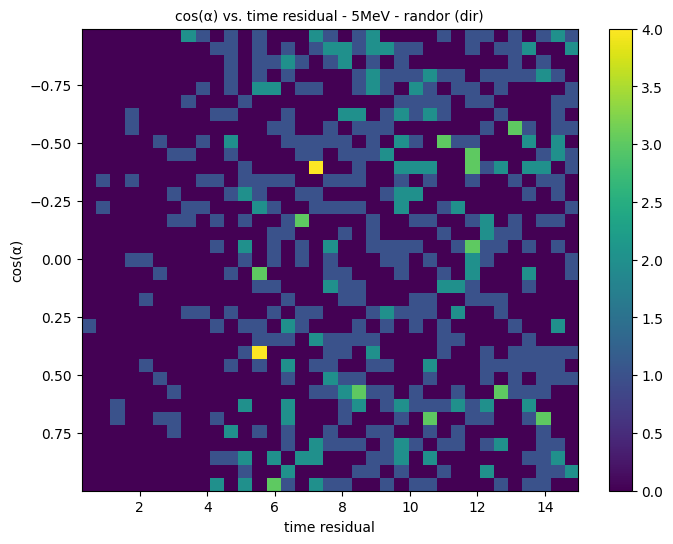

In [331]:
bins = 35

if radi_cut_method == True:
    title = 'cos(α) vs. time Residual - 5MeV - randor (dir) \n volume cut r(mm) < '+str(rad_cut_val)

else:
    title = 'cos(α) vs. time residual - 5MeV - randor (dir)'


xlabel = 'time residual'
ylabel = 'cos(α)'

H_ev, xedges, yedges = np.histogram2d(x = cos_angel_ev, y =  time_residual_ev, bins = [bins, bins])

# plot limits
left_ev = np.min(time_residual_ev)
right_ev = np.max(time_residual_ev)
bottom_ev = np.min(cos_angel_ev)
top_ev = np.max(cos_angel_ev)

plt.figure(figsize=(8,6))
plt.imshow(H_ev, extent = [left_ev, right_ev, top_ev, bottom_ev], aspect="auto" ) #---> Here is our image as a Matrix Pixel
plt.title(title, fontsize= 10)
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.colorbar()

#### - Fake EV Histogram

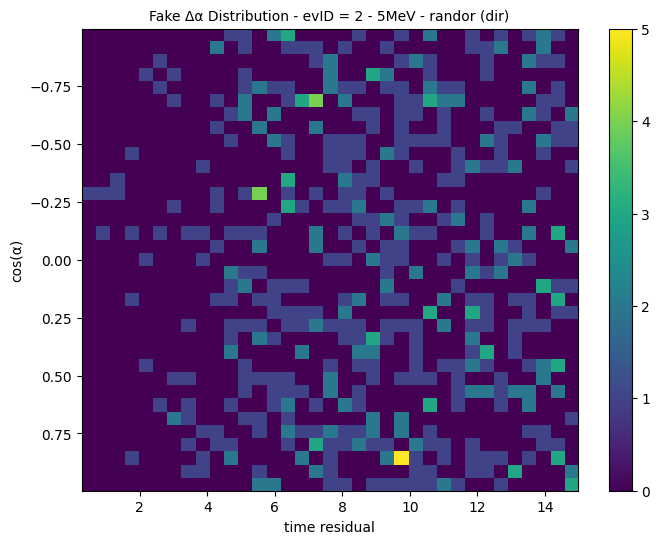

In [332]:
bins = 35

if radi_cut_method == True:
    title = 'Fake cos(α) vs. time Residual - 5MeV - randor (dir) \n volume cut r(mm) < '+str(rad_cut_val)

else:
    title = 'Fake Δα Distribution - evID = ' + str(id_i) + ' - 5MeV - randor (dir)'


xlabel = 'time residual'
ylabel = 'cos(α)'

H_ev_fake, xedges, yedges = np.histogram2d(x = pse_cos_angel_ev, y =  time_residual_ev, bins = [bins, bins])

# plot limits
left_ev = np.min(time_residual_ev)
right_ev = np.max(time_residual_ev)
bottom_ev = np.min(pse_cos_angel_ev)
top_ev = np.max(pse_cos_angel_ev)

plt.figure(figsize=(8,6))
plt.imshow(H_ev_fake, extent = [left_ev, right_ev, top_ev, bottom_ev], aspect="auto" ) #---> Here is our image as a Matrix Pixel
plt.title(title, fontsize= 10)
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.colorbar()
plt.savefig('figs/Single Event/pseudo direction/35x35/' + title + '.png', format = 'png')

### 3.1.1 - Normalization singleEV

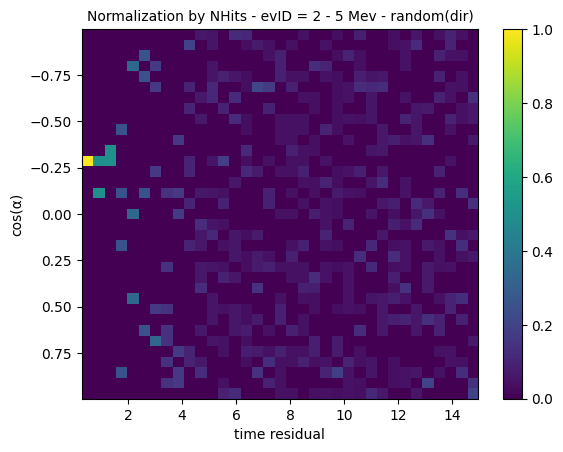

In [333]:
sum_hit_ev = np.sum(H_ev_fake,axis=0)
H_ev_Hit_norm = H_ev_fake/sum_hit_ev

N_ev_title = 'Normalization by NHits - evID = ' + str(id_i) + ' - 5 Mev - random(dir)'

plt.imshow(H_ev_Hit_norm, extent = [left_ev, right_ev, top_ev, bottom_ev], aspect="auto")
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.title(N_ev_title, fontsize = 10)
plt.colorbar()
plt.savefig('figs/Single Event/pseudo direction/35x35/' + N_ev_title + '.png', format = 'png')

## 3.2 - All event Histogram

In [319]:
H, xedges, yedges = np.histogram2d(x = multi_cos_angle_cut, y =  multi_time_residual_cut, bins = [bins, bins])

left = np.min(multi_time_residual_cut)
right = np.max(multi_time_residual_cut)
bottom = np.min(multi_cos_angle_cut)
top = np.max(multi_cos_angle_cut)

### 3.2.1 - MultiEV Normalization

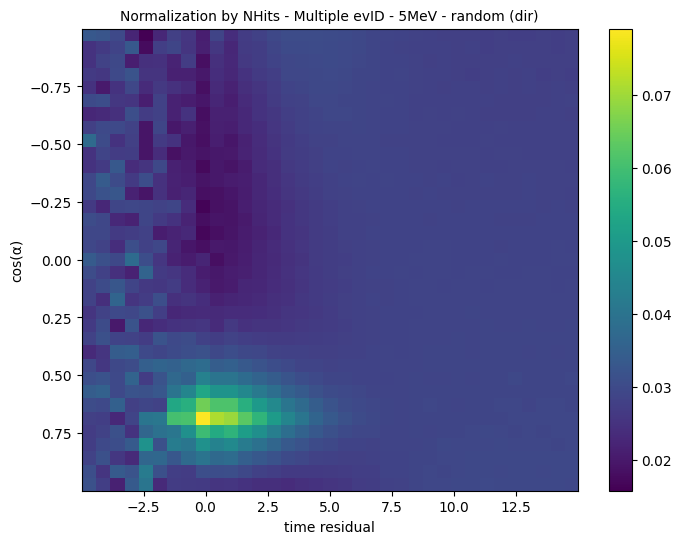

In [303]:
## sum of hits in each bin = sum over each column element of the matrix.
sum_hit = np.sum(H,axis=0)  

H_Hit_norm = H / sum_hit

if radi_cut_method == True:
    N1title = 'Normalization by NHits - Multiple evID - 5MeV - random (dir) \n volume cut r(mm) < '+str(rad_cut_val)

else:
    N1title = 'Normalization by NHits - Multiple evID - 5MeV - random (dir)'

plt.figure(figsize=(8,6))
#plt.imshow(H_Hit_norm, aspect="auto")
plt.imshow(H_Hit_norm, extent = [left, right, top, bottom], aspect="auto")
plt.title(N1title, fontsize= 10)
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.colorbar()
#plt.savefig('figs/High Stat/' + N1title + '_' + str(bins) + '.png', format = 'png')

# 4 - Recognition using Templates

## 4.1 - Load and Loop Over Templates and Events

In [17]:
#Loop over events

#Choose number of events
N_evs = 19                                      #real number of events is N_evs + 1
index_list = np.arange(0,N_evs + 1,1)

for ev_i in index_list:

    #consecutive single events
    i = break_i[ev_i]
    f = break_i[ev_i+1]
    time_residual_ev = np.array(multi_time_residual_cut[i:f])
    cos_angel_ev = np.array(multi_cos_angle_cut[i:f])
    
    # 2DHistrogram of single event:
    xlabel = 'time residual'
    ylabel = 'cos(α)'

    H, xedges, yedges = np.histogram2d(x = cos_angel_ev, y =  time_residual_ev, bins = [bins, bins])
    
    if radi_cut_method == True:
        title = 'cos(α) vs. time Residual - evID =' + str(ev_i) + '- 5MeV - randor (dir) \n volume cut r(mm) < '+str(rad_cut_val)
    
    else:
        title = 'cos(α) vs. time residual - evID =' + str(ev_i) + ' - 5MeV - randor (dir)'

    left = np.min(time_residual_ev)
    right = np.max(time_residual_ev)
    bottom = np.min(cos_angel_ev)
    top = np.max(cos_angel_ev)
    
    plt.figure(figsize=(8,6))
    plt.imshow(H, extent = [left, right, top, bottom], aspect="auto" ) #---> Here is our image as a Matrix Pixel
    plt.title(title, fontsize= 10)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.colorbar()
    plt.savefig('figs/Single Event/single ev histogram/'+str(bins)+'x'+str(bins)+'/' + title + '_' +str(bins) + '.png', format = 'png')
    
    #Loop over templates
    template_sample = [1, 2, 3, 4, 5]
    
    for sample_i in template_sample:
        template = np.genfromtxt('Template Arrays/'+str(bins)+'x'+str(bins)+'/template('+str(sample_i)+').csv', delimiter=',')
        
        #normalize data before match.Template method
        H_norm = cv.normalize(H, None, alpha = 0, beta = 255, norm_type=cv.NORM_MINMAX)
        template_norm = cv.normalize(template, None, alpha = 0, beta = 255, norm_type=cv.NORM_MINMAX)
        
        #rescaling images after normlazitaion -> necessary to be accepte by match.template()!
        H_T = H_norm.astype(np.uint8) #Ideal: np.uint16
        template_T = template_norm.astype(np.uint8)  #Ideal: np.float16
    
        # Choose method
        method = eval('cv.TM_CCOEFF')
        
        #Apply template matching
        match_res = cv.matchTemplate(H_T, template_T, method)
        
        # obtain the maximum value
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(match_res)  #obtain maximun and minimun values and location of array
        
        # Localizar donde esta el maximo en la imagen usando un rectangulo
        h, w = np.shape(template_norm)
        top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
            
        #plots 
        #template
        title = 'Template('+str(sample_i)+')'
        plt.imshow(template)
        plt.title(title)
        plt.savefig('figs/Single Event/template matching/'+str(bins)+'x'+str(bins)+'/'+title+'.png', format = 'png')
        
        #Matching
        title = 'Matching Result('+str(sample_i)+')'+ ' evID =' + str(ev_i)
        plt.imshow(match_res)
        plt.title(title)
        plt.savefig('figs/Single Event/template matching/'+str(bins)+'x'+str(bins)+'/'+title+'.png', format = 'png')
        
        #recognition
        title = 'Pattern Identification('+str(sample_i)+')' + ' evID =' + str(ev_i)
        ROI_ident = cv.rectangle(H_T, top_left, bottom_right, color = 255, thickness = 1)
        plt.imshow(ROI_ident, extent = [left, right, top, bottom], aspect = 'auto')
        plt.title(title)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.savefig('figs/Single Event/template matching/'+str(bins)+'x'+str(bins)+'/' +title+'.png', format = 'png')
#dont show figures here        
plt.close('all')

# 5 - Comparación Directa de Δα_ev con NormHits(Δα_multi_ev)

## 5.1 - Operar entre Imagen Normalizada y Imagen de Single Event

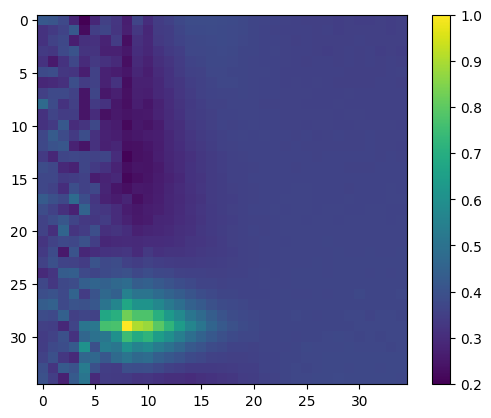

In [242]:
#rescale norm_image:
H_Hit_norm *= 1/(H_Hit_norm.max())
#H_ev *= 7/(H_ev.max())
plt.imshow(H_Hit_norm)
plt.colorbar()

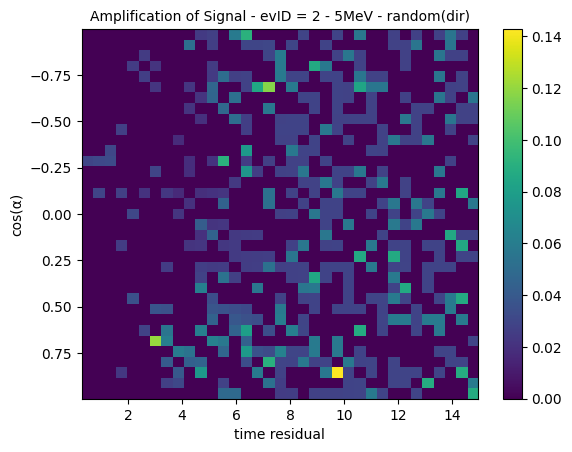

In [334]:
H_ev_prod = H_Hit_norm*H_ev_fake  #Observacion-> El produto entre imagen normalizada multi_ev y imagen de single_ev Amplifican los datos en ROI!
#ratio = H_ev/H_Hit_norm
prod_title = 'Amplification of Signal - evID = ' + str(id_i) + ' - 5MeV - random(dir)'
plt.imshow(H_ev_prod, extent = [left_ev, right_ev, top_ev, bottom_ev], aspect="auto")
plt.title(prod_title, fontsize = 10)
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.colorbar()
#plt.savefig('figs/Single Event/pseudo direction/35x35/' + prod_title + '.png', format = 'png')

## 5.2 - Intentar otra vez Template Matching

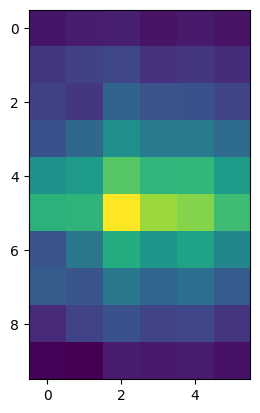

In [305]:
#choose region of template
H_template = H_Hit_norm[24:34, 6:12] 
# [25:33, 7:12] 
plt.imshow(H_template)

In [335]:
#normalize data before match.Template method
H_ev_norm = cv.normalize(H_ev_prod, None, alpha = 0, beta = 255, norm_type=cv.NORM_MINMAX)
H_template_norm = cv.normalize(H_template, None, alpha = 0, beta = 255, norm_type=cv.NORM_MINMAX)

#rescaling images after normlazitaion -> necessary to be accepte by match.template()!
H_T = H_ev_norm.astype(np.uint8) #Ideal: np.uint16
H_template_T = H_template_norm.astype(np.uint8)  #Ideal: np.float16

In [336]:
# Choose method
#method = eval('cv.TM_CCOEFF')  #No eficaz
method = eval('cv.TM_CCORR')    #Eficaz

#Apply template matching
match_res = cv.matchTemplate(H_T, H_template_T, method)

# obtain the maximum value
min_val, max_val, min_loc, max_loc = cv.minMaxLoc(match_res)  #obtain maximun and minimun values and location of array

Text(0.5, 1.0, 'Matching Result - evID = 2 - 5 MeV - random(dir)')

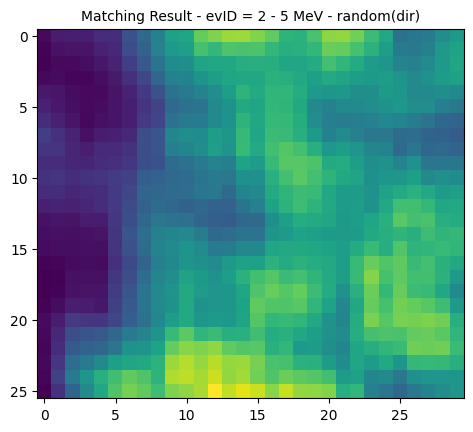

In [337]:
title = 'Matching Result - evID = ' + str(id_i) + ' - 5 MeV - random(dir)'
plt.imshow(match_res)
plt.title(title, fontsize = 10)
#plt.savefig('figs/Single Event/pseudo direction/35x35/' + title + '.png', format = 'png')

Text(0.5, 1.0, 'Pattern Identification - evID = 2 - 5 MeV - random(dir)')

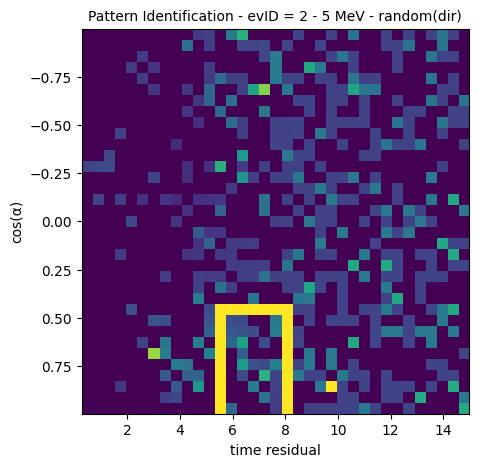

In [338]:
# Localizar donde esta el maximo en la imagen usando un rectangulo

h, w = np.shape(H_template_T)
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)

ROI_ident = cv.rectangle(H_T, top_left, bottom_right, color = 255, thickness = 1)

title = 'Pattern Identification - evID = '+ str(id_i) + ' - 5 MeV - random(dir)'
plt.figure(figsize=(5,5))
plt.imshow(ROI_ident, extent = [left_ev, right_ev, top_ev, bottom_ev], aspect="auto")
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.title(title, fontsize = 10)
#plt.savefig('figs/Single Event/template matching/35x35/Amplify signal/'+title+'.png', format = 'png')

## 5.3 - Producto de Plots Normalizados

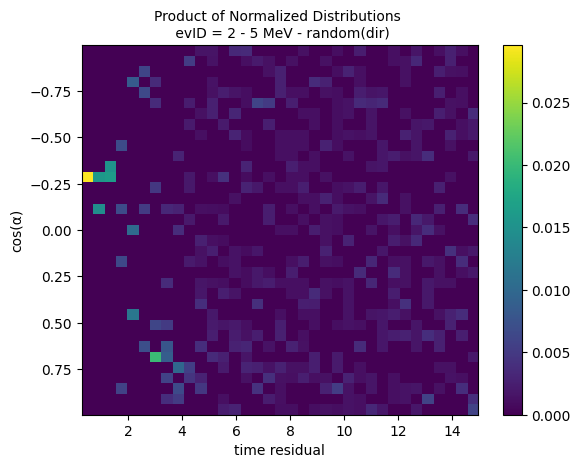

In [339]:
norm_prod = H_ev_Hit_norm*H_Hit_norm

title = 'Product of Normalized Distributions \n evID = ' + str(id_i) + ' - 5 MeV - random(dir)'
#plt.figure(figsize=(5,5))
plt.imshow(norm_prod, extent = [left_ev, right_ev, top_ev, bottom_ev], aspect="auto")
plt.title(title, fontsize = 10)
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.colorbar()
plt.savefig('figs/Single Event/pseudo direction/35x35/Product of Normalized Distributions - evID = ' + str(id_i) + '.png', format = 'png')

In [340]:
#normalize data before match.Template method
#H_ev_norm = cv.normalize(H_ev_Hit_norm, None, alpha = 0, beta = 255, norm_type=cv.NORM_MINMAX)
H_ev_norm = cv.normalize(norm_prod, None, alpha = 0, beta = 255, norm_type=cv.NORM_MINMAX)
H_template_norm = cv.normalize(H_template, None, alpha = 0, beta = 255, norm_type=cv.NORM_MINMAX)

#rescaling images after normlazitaion -> necessary to be accepte by match.template()!
H_T = H_ev_norm.astype(np.uint8) #Ideal: np.uint16
H_template_T = H_template_norm.astype(np.uint8)  #Ideal: np.float16

#Observaciones:
#- usando el producto de likelihoods la deteccion del patron resulta mas eficaz que simplemente introduciendo la 

In [341]:
# Choose method
#method = eval('cv.TM_CCOEFF') #No eficaz
method = eval('cv.TM_CCORR')  #Eficaz
#method = eval('cv.TM_CCOEFF_NORMED') #No eficaz

#Apply template matching
match_res = cv.matchTemplate(H_T, H_template_T, method)

# obtain the maximum value
min_val, max_val, min_loc, max_loc = cv.minMaxLoc(match_res)  #obtain maximun and minimun values and location of array

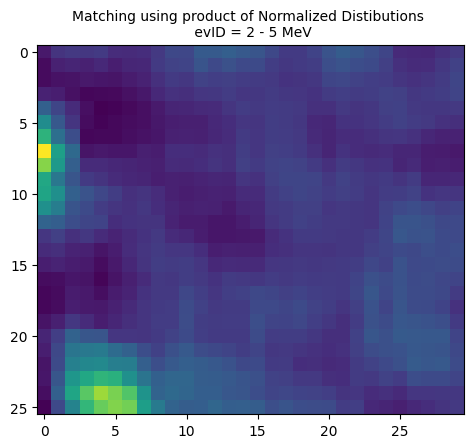

In [342]:
title = 'Matching using product of Normalized Distibutions \n evID = '+str(id_i)+' - 5 MeV'
plt.imshow(match_res)
plt.title(title, fontsize = 10)
plt.savefig('figs/Single Event/pseudo direction/35x35/Matching prod. Normalized Distibutions - evID='+ str(id_i)+'.png', format = 'png')

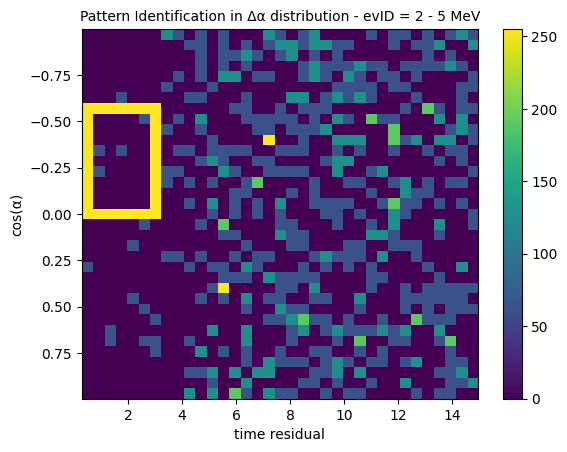

In [343]:
#Normalizar y tranformar imagen de evento individual
H_norm_ev = cv.normalize(H_ev, None, alpha = 0, beta = 255, norm_type=cv.NORM_MINMAX)
H_ev_T = H_norm_ev.astype(np.uint8)

# Localizar donde esta el maximo en la imagen usando un rectangulo

h, w = np.shape(H_template_T)
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)

ROI_ident = cv.rectangle(H_ev_T, top_left, bottom_right, color = 255, thickness = 1)

title = 'Pattern Identification in Δα distribution - evID = ' + str(id_i) + ' - 5 MeV'
plt.imshow(ROI_ident, extent = [left_ev, right_ev, top_ev, bottom_ev], aspect="auto")
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.title(title, fontsize = 10)
plt.colorbar()
plt.savefig('figs/Single Event/pseudo direction/35x35/' + title + '.png', format = 'png')